# Exploring Storm Data with Wherobots

This notebook introduces how to use the NOAA Severe Weather Data Inventory (SWDI) on Wherobots.

We will:

- Load CSV-formatted storm event data from an AWS S3 bucket.
- Prepare the data for geospatial queries by converting lat/long columns into a single `POINT` column.
- Load 2-dimensional geometry to use in a filter over the severe weather points.
- Visualize the points and the surrounding geography on an interactive map using SedonaKepler.

## Why use Wherobots for storm data?

The size and complexity of storm event data can make it hard or expensive to analyze.
Wherobots helps you write fast and cost-efficient analytics with:

- **Lazy Loading** → Data is pulled into memory only when needed to run a query.
- **Distributed Query Execution** → Join and filter without moving large files.
- **Fast Geospatial Filtering** → Quickly combine and compare just the relevant data based on its geography.

Wherobots also makes it easy to seamlessly **combine vector and raster data.** We can analyze the NOAA vector 
storm data along with:

- Administrative boundaries (counties, states, etc.)
- Critical infrastructure (power grids, highways, etc.)
- Other meteorological data (temperature, precipitation, etc.)

This makes Wherobots ideal for storm tracking, risk assessment, and severe weather analytics.

## What is NOAA SWDI?

The [NOAA Severe Weather Data Inventory (SWDI)](https://www.ncdc.noaa.gov/swdi/) aggregates severe 
weather records from multiple sources, including:

- NEXRAD Level-3 products (tornado vortex signatures, hail signatures, mesocyclones)
- Storm warnings (severe thunderstorm, tornado, flash flood, and special marine warnings)
- Vaisala’s National Lightning Detection Network (NLDN)
- Storm cell structures (size, rotation, etc.)

### How is this data useful?

The SWDI dataset can answer key public safety and business questions across many domains, including: 

- Insurance & Risk Analysis – Assessing hailstorm damage and storm frequency
- Disaster Response Planning – Understanding severe storm patterns for emergency planning
- Climate Change Studies – Analyzing shifts in extreme weather events
- Storm Tracking & Forecasting – Validating storm prediction models 

### Data files

The SWDI dataset contains smaller datasets of different aspects of storm activity.  

| **Dataset**       | **Description**                                             | **File Naming Convention** |
|-------------------|-------------------------------------------------------------|----------------------------|
| Hail Reports      | NEXRAD Level-3 Hail Signatures, including size and severity | `hail-YYYY.csv`            |
| Hail Tiles        | Hail data aggregated by spatial tiles                       | `hail-tiles-YYYY.csv`      |
| Mesocyclones      | Rotational features in storms detected by radar             | `meso-YYYY.csv`            |
| Mesocyclone Tiles | Mesocyclone data aggregated by tiles                        | `meso-tiles-YYYY.csv`      |
| Tornado Vortex Signatures (TVS) | Radar-detected tornado signatures             | `tvs-YYYY.csv`             |
| TVS Tiles         | Tornado vortex signatures aggregated by tiles               | `tvs-tiles-YYYY.csv`       |
| Storm Structure   | NEXRAD Level-3 storm cell data, including size and intensity | `structure-YYYY.csv`      |
| Storm Structure Tiles | Aggregated storm structure data by spatial tiles        | `structure-tiles-YYYY.csv` |
| Lightning Strikes | Lightning detection data (restricted access)                | `nldn-YYYY.csv`            |
| Storm-Based Warnings | Official severe weather warnings from NOAA               | `warn-YYYY.csv`            |

### Data contents

- Date range: 1995 to the present, updated monthly
- Formats: CSV, Shapefiles, KMZ, JSON, XML  
- Open access on AWS Marketplace: `s3://noaa-swdi-pds/`  
- File granularity: Aggregated by year for past years and by month for the current year

# Writing the code

## Set up an Apache Sedona context

The context, `sedona`, is the machine that runs in the Wherobots Cloud compute environment. To connect to the SWDI data on AWS, 
we add anonymous S3 access credentials when we call `SedonaContext.builder().getOrCreate()`. 
You can read [our documentation](https://docs.wherobots.com/latest/develop/notebook-management/notebook-instance-management/) 
about how to further configure the Sedona context.

In [ ]:
from sedona.spark import *

try:
    sedona
except NameError:
    config = SedonaContext.builder() \
    .config("fs.s3a.bucket.noaa-swdi-pds.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .config("spark.hadoop.fs.s3a.bucket.noaa-swdi-pds.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider") \
    .getOrCreate()
    sedona = SedonaContext.create(config)

## Load and prepare SWDI hailstorm data

We will load two types of storm data into Wherobots DataFrames. First, we will work with NEXRAD Level-3 Hail Signatures:

1. Load 12.2M point locations of hail storm signatures from 2023.
2. Use the `ST_Intersects()` spatial filter to find the storms contained within a region.
3. Use Sedona Kepler to draw a map of those storms, coloring each storm by the size of the hail.

### Read NEXRAD Level-3 Hail Signatures

Using PySpark, we will read the CSV file with 2023 hail signatures. The file starts like this:

```
#This file contains experimental data.
#File written at Sun Feb  5 09:35:10 EST 2023.
#ZTIME,LON,LAT,WSR_ID,CELL_ID,RANGE,AZIMUTH,SEVPROB,PROB,MAXSIZE
20230101000145,-76.98093,33.78684,KRAX,K7,135,146,-999,-999,-999
20230101000145,-75.84620,36.05329,KRAX,D8,131,79,-999,-999,-999
...
```

We load and prepare the data by:

- Skipping the comment lines in the header
- Keeping the CSV file's column names in our dataframe
- Parsing the timestamp string
- Converting the LON and LAT columns into a single *Sedona point geometry column* that can be used efficiently in geospatial queries

In [ ]:
%%time

from pyspark.sql.functions import expr, col, to_timestamp

dataset = 'hail'
year = '2023'
s3_uri = f"s3://noaa-swdi-pds/{dataset}-{year}.csv"
column_names = ['ZTIME', 'LON', 'LAT', 'WSR_ID', 'CELL_ID', 'RANGE', 'AZIMUTH', 'SEVPROB', 'PROB', 'MAXSIZE']

hail_df = sedona.read.option("comment", "#")\
                .csv(s3_uri)\
                .toDF(*column_names)\
                .withColumn("ZTIME", to_timestamp(col("ZTIME"), "yyyyMMddHHmmss"))\
                .withColumn("geometry", expr("ST_Point(LON, LAT)"))

hail_df.cache().count()

In [ ]:
hail_df.show(5)

### Filter to storms inside Texas on April 28th, 2023

To filter to Texas, we will first grab the geometry of Texas from the `divisions_division_area` table in the Overture Maps Foundation dataset, hosted in the Wherobots Open Data catalog.

In [ ]:
texas_geometry = sedona.table("wherobots_open_data.overture_maps_foundation.divisions_division_area")\
                    .where(col("subtype") == "region")\
                    .where(col("region") == "US-TX")\
                    .selectExpr("geometry").collect()[0][0]

texas_geometry

Next, we will filter to a specific date and use the Wherobots `ST_Intersects` predicate function to find the points inside `texas_geometry`.

In [ ]:
%%time
from pyspark.sql.functions import year, to_date

texas_hail_20230428_df = hail_df.withColumn("date", to_date("ZTIME"))\
                        .where(to_date("ZTIME") == "2023-04-28")\
                        .where(expr(f"ST_Intersects(geometry, ST_GeomFromEWKT('{texas_geometry}'))"))

### Visualize the hailstorms on a map

Finally, we create an interactive map using SedonaKepler. We pull the county boundaries from the open Overture Maps Foundation
dataset to use as a layer on the map.

In [ ]:
texas_counties_df = sedona.table("wherobots_open_data.overture_maps_foundation.divisions_division_area")\
                    .where(col("subtype") == "county")\
                    .where(col("region") == "US-TX")\
                    .select("geometry", "names.primary")

texas_counties_df.show(5)

And configure the map with a JSON map config ([docs](https://docs.kepler.gl/docs/keplergl-jupyter#id-4.-customize-the-map))
so that storms with larger hailstones have a darker color.

In [ ]:
map_config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'moqp08f', 'type': 'geojson', 'config': {'dataId': 'hail', 'label': 'hail', 'color': [255, 153, 31], 'highlightColor': [252, 242, 26, 255], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 0.1, 'strokeColor': [255, 254, 230], 'colorRange': {'name': 'ColorBrewer PuBu-6', 'type': 'sequential', 'category': 'ColorBrewer', 'colors': ['#f1eef6', '#d0d1e6', '#a6bddb', '#74a9cf', '#2b8cbe', '#045a8d'], 'reversed': False}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': True, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center', 'outlineWidth': 0, 'outlineColor': [255, 0, 0, 255], 'background': False, 'backgroundColor': [0, 0, 200, 255]}]}, 'visualChannels': {'colorField': {'name': 'MAXSIZE', 'type': 'real'}, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'jkl0v3o', 'type': 'geojson', 'config': {'dataId': 'counties', 'label': 'counties', 'color': [254, 137, 26], 'highlightColor': [252, 242, 26, 255], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.2, 'strokeOpacity': 0.2, 'thickness': 0.5, 'strokeColor': [34, 63, 154], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': True, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center', 'outlineWidth': 0, 'outlineColor': [255, 0, 0, 255], 'background': False, 'backgroundColor': [0, 0, 200, 255]}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'effects': [], 'interactionConfig': {'tooltip': {'fieldsToShow': {'hail': [{'name': 'ZTIME', 'format': None}, {'name': 'MAXSIZE', 'format': None}, {'name': 'SEVPROB', 'format': None}, {'name': 'PROB', 'format': None}], 'counties': [{'name': 'primary', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'overlayBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}, 'editor': {'features': [], 'visible': True}}, 'mapStyle': {'styleType': 'dark-matter', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [15.035172933000911, 15.035172933000911, 15.035172933000911], 'backgroundColor': [0, 0, 0], 'mapStyles': {}}}}

In [ ]:
texas_hail_20230428_map = SedonaKepler.create_map(texas_hail_20230428_df.where(col("date") == "2023-04-28"), name="hail", config=map_config)
SedonaKepler.add_df(texas_hail_20230428_map, texas_counties_df, name = "counties")

texas_hail_20230428_map

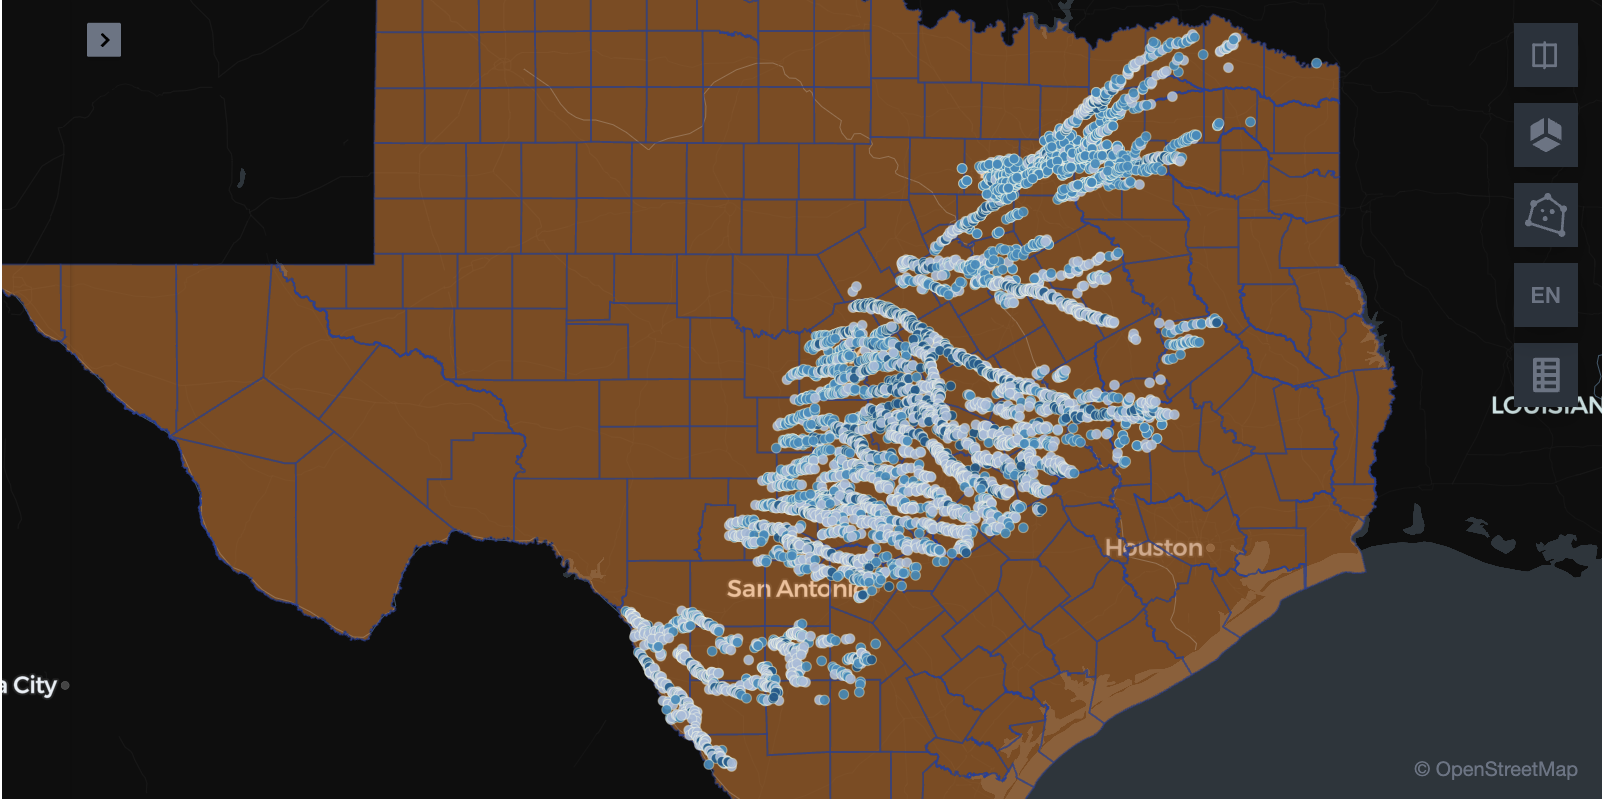

### Read NEXRAD Level-3 storm cell data

Next, we'll do a similar process for 38.8M points of storm data in Oklahoma for a single day from 2023.

In [ ]:
hail_df.unpersist()

In [ ]:
%%time
from pyspark.sql.functions import expr, col, to_timestamp

dataset = 'structure'
year = '2023'
s3_uri = f"s3://noaa-swdi-pds/{dataset}-{year}.csv"
columns_names = ['ZTIME', 'LON', 'LAT', 'WSR_ID', 'CELL_ID', 'RANGE', 'AZIMUTH', 'BASE_HEIGHT', 'TOP_HEIGHT', 'VIL', 'MAX_REFLECT', 'HEIGHT']

# Read storm cell CSV file for 2023 and convert LAT/LON to POINT geometry
storm_df = sedona.read.option("comment", "#")\
                .csv(s3_uri)\
                .toDF(*columns_names)\
                .withColumn("ZTIME", to_timestamp(col("ZTIME"), "yyyyMMddHHmmss"))\
                .withColumn("geometry", expr("ST_Point(LON, LAT)"))

storm_df.cache().count()

In [ ]:
# Get geometry of Oklahoma to filter with ST_Intersects
oklahoma_geometry = sedona.table("wherobots_open_data.overture_maps_foundation.divisions_division_area")\
                    .where(col("subtype") == "region")\
                    .where(col("region") == "US-OK")\
                    .selectExpr("geometry").collect()[0][0]

oklahoma_geometry

In [ ]:
from pyspark.sql.functions import year, to_date

# Filter to Oklahoma on April 27, 2023
oklahoma_storm_20230427_df = storm_df.withColumn("date", to_date("ZTIME"))\
                        .where(to_date("ZTIME") == "2023-04-27")\
                        .where(expr(f"ST_Intersects(geometry, ST_GeomFromEWKT('{oklahoma_geometry}'))"))

oklahoma_storm_20230427_df.count()

In [ ]:
# Pull the geometry of Oklahoma counties to use as a map layer
oklahoma_counties_df = sedona.table("wherobots_open_data.overture_maps_foundation.divisions_division_area")\
                    .where(col("subtype") == "county")\
                    .where(col("region") == "US-OK")\
                    .select("geometry", "names.primary")

oklahoma_counties_df.show(5)

In [ ]:
# Encode VIL (Vertically Integrated Liquid) on color
map_config = {'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'moqp08f', 'type': 'geojson', 'config': {'dataId': 'storm', 'label': 'storm', 'color': [255, 153, 31], 'highlightColor': [252, 242, 26, 255], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.8, 'strokeOpacity': 0.8, 'thickness': 0.1, 'strokeColor': [255, 254, 230], 'colorRange': {'name': 'ColorBrewer PuBu-6', 'type': 'sequential', 'category': 'ColorBrewer', 'colors': ['#f1eef6', '#d0d1e6', '#a6bddb', '#74a9cf', '#2b8cbe', '#045a8d'], 'reversed': False}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': True, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center', 'outlineWidth': 0, 'outlineColor': [255, 0, 0, 255], 'background': False, 'backgroundColor': [0, 0, 200, 255]}]}, 'visualChannels': {'colorField': {'name': 'VIL', 'type': 'integer'}, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}, {'id': 'jkl0v3o', 'type': 'geojson', 'config': {'dataId': 'counties', 'label': 'counties', 'color': [254, 137, 26], 'highlightColor': [252, 242, 26, 255], 'columns': {'geojson': 'geometry'}, 'isVisible': True, 'visConfig': {'opacity': 0.2, 'strokeOpacity': 0.2, 'thickness': 0.5, 'strokeColor': [34, 63, 154], 'colorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'strokeColorRange': {'name': 'Global Warming', 'type': 'sequential', 'category': 'Uber', 'colors': ['#5A1846', '#900C3F', '#C70039', '#E3611C', '#F1920E', '#FFC300']}, 'radius': 10, 'sizeRange': [0, 10], 'radiusRange': [0, 50], 'heightRange': [0, 500], 'elevationScale': 5, 'enableElevationZoomFactor': True, 'stroked': True, 'filled': True, 'enable3d': False, 'wireframe': False}, 'hidden': False, 'textLabel': [{'field': None, 'color': [255, 255, 255], 'size': 18, 'offset': [0, 0], 'anchor': 'start', 'alignment': 'center', 'outlineWidth': 0, 'outlineColor': [255, 0, 0, 255], 'background': False, 'backgroundColor': [0, 0, 200, 255]}]}, 'visualChannels': {'colorField': None, 'colorScale': 'quantile', 'strokeColorField': None, 'strokeColorScale': 'quantile', 'sizeField': None, 'sizeScale': 'linear', 'heightField': None, 'heightScale': 'linear', 'radiusField': None, 'radiusScale': 'linear'}}], 'effects': [], 'interactionConfig': {'tooltip': {'fieldsToShow': {'counties': [{'name': 'primary', 'format': None}], 'storm': [{'name': 'ZTIME', 'format': None}, {'name': 'LON', 'format': None}, {'name': 'LAT', 'format': None}, {'name': 'WSR_ID', 'format': None}, {'name': 'CELL_ID', 'format': None}]}, 'compareMode': False, 'compareType': 'absolute', 'enabled': True}, 'brush': {'size': 0.5, 'enabled': False}, 'geocoder': {'enabled': False}, 'coordinate': {'enabled': False}}, 'layerBlending': 'normal', 'overlayBlending': 'normal', 'splitMaps': [], 'animationConfig': {'currentTime': None, 'speed': 1}, 'editor': {'features': [], 'visible': True}}, 'mapState': {'bearing': 0, 'dragRotate': False, 'latitude': 35.37345816671503, 'longitude': -97.45340016562497, 'pitch': 0, 'zoom': 6, 'isSplit': False, 'isViewportSynced': True, 'isZoomLocked': False, 'splitMapViewports': []}, 'mapStyle': {'styleType': 'dark-matter', 'topLayerGroups': {}, 'visibleLayerGroups': {'label': True, 'road': True, 'border': False, 'building': True, 'water': True, 'land': True, '3d building': False}, 'threeDBuildingColor': [15.035172933000911, 15.035172933000911, 15.035172933000911], 'backgroundColor': [0, 0, 0], 'mapStyles': {}}}}

In [ ]:
# Create an interactive map using SedonaKepler
oklahoma_storm_20230427_map = SedonaKepler.create_map(oklahoma_storm_20230427_df.where(col("date") == "2023-04-27"), name="storm", config=map_config)
SedonaKepler.add_df(oklahoma_storm_20230427_map, oklahoma_counties_df, name = "counties")

oklahoma_storm_20230427_map

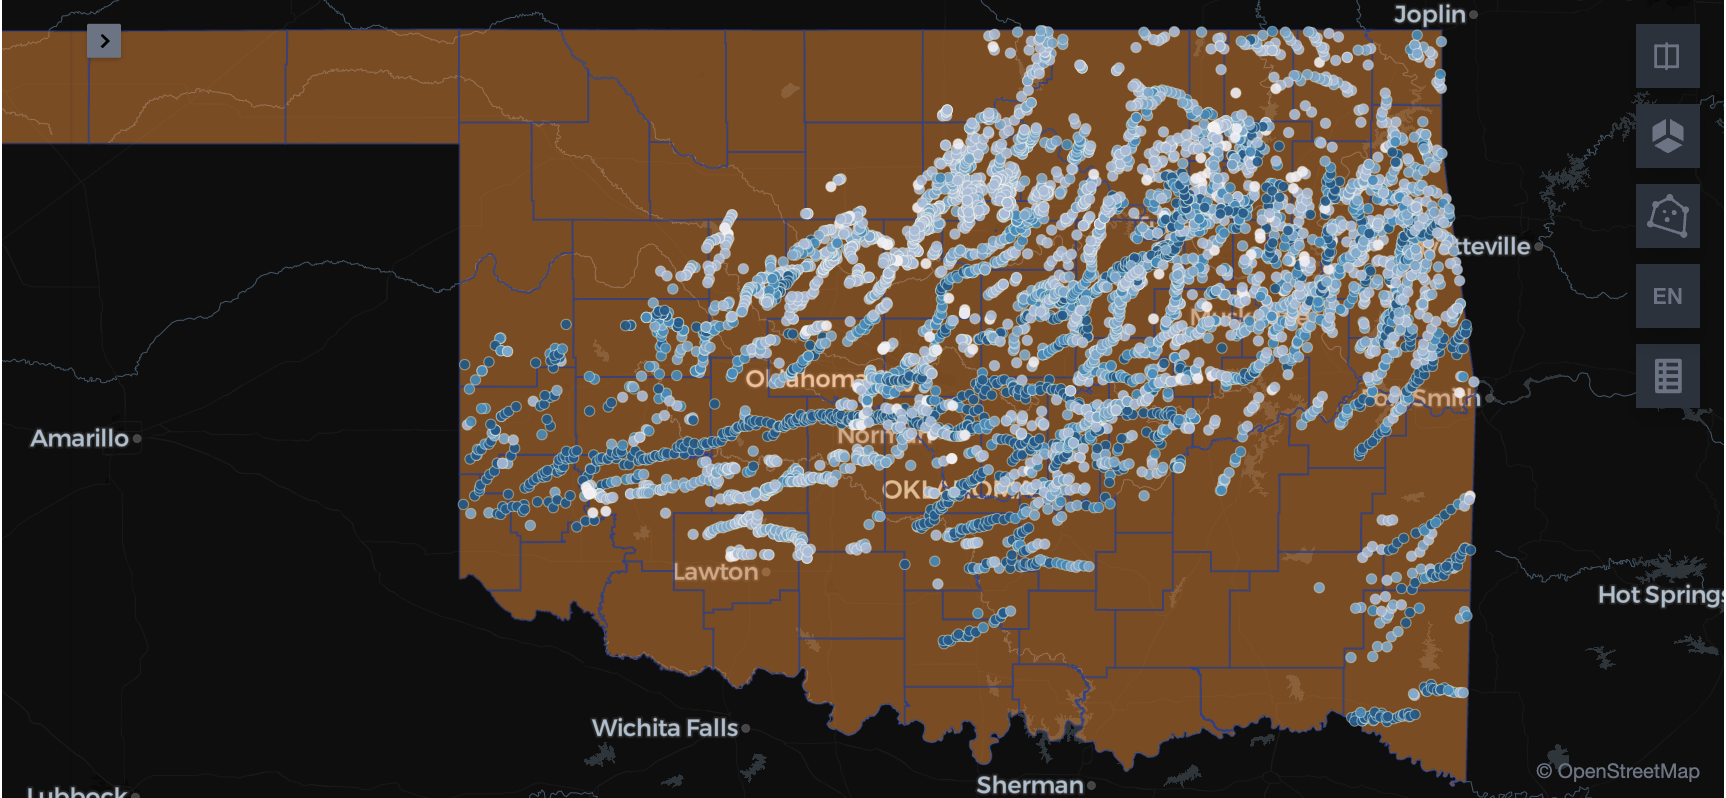